## Modeling
This is the notebook with the model research in order to get as good MAPE as possible

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import xgboost as xgb

import mlflow

import IPython.display as ipd
import seaborn as sns
import matplotlib.pylab as plt

In [11]:
data = pd.read_csv(os.path.join('..', 'data', 'processed', 'ubaar_features.csv'), encoding="utf-8", index_col="ID")

In [12]:
data.shape

(49371, 52)

In [13]:
features_columns = data.columns
# features_columns = [c for c in features_columns if not c.startswith('cluster_')]
# features_columns = [c for c in features_columns if not c.startswith('weight_d')]
features_columns = list(features_columns)
features_columns.remove('price')
features_columns = np.array(features_columns)

In [14]:
# features_columns = data.columns[data.columns  != 'price'].values

In [15]:
def setup_mlflow():
    remote_server_uri = "http://18.185.244.61:5050"
    mlflow.set_tracking_uri(remote_server_uri)
    mlflow.set_experiment("UbaarCV") 
    mlflow.end_run()
    mlflow.start_run(run_name='')

In [16]:
def train_sklearn(x_train, y_train, x_dev, y_dev):
#     model = Ridge(alpha=5.0, fit_intercept=True, normalize=False, copy_X=True, solver='auto', random_state=42)
    model = RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=8, random_state=42)
    
    
    model.fit(x_train, np.log(y_train * 0.95))

    preds_train = np.exp(model.predict(x_train))
    preds_dev = np.exp(model.predict(x_dev))

    return preds_train, preds_dev, model.__dict__, model

PARAMS = {'objective': 'reg:squarederror',
          'eval_metric': 'mape',
         'booster': 'gbtree', 'eta': 0.05, 'max_depth': 16,
         'min_child_weight': 0.01,
         'subsample': 0.9, 'colsample_bytree': 0.6,
         'colsample_bylevel': 0.1, 'alpha': 0.0,
         'lambda': 0.5, 'seed': 42, 'gamma': 0.0,
         'max_delta_step': 0}

def train_xgb(x_train, y_train, x_dev, y_dev):
    
    dtrain = xgb.DMatrix(x_train, label=np.log(y_train * 0.95))
    dtest = xgb.DMatrix(x_dev, label=np.log(y_dev * 0.95))
    evallist = [(dtest, 'eval')]
    
    model = xgb.train(PARAMS, dtrain, 3000, evals=evallist, verbose_eval=False, early_stopping_rounds=500)
    preds_train = np.exp(model.predict(dtrain, model.best_iteration+0))
    preds_dev = np.exp(model.predict(dtest, model.best_iteration+0))
#     print(model.best_iteration)
    model_params = PARAMS
    return preds_train, preds_dev, model_params, model
    

In [17]:
setup_mlflow()
mlflow.log_param('features', features_columns)


y_full = data['price'].values
x_full = data[features_columns].values

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_mapes = []
dev_mapes = []
dev_preds = []
dev_refs = []
dev_inds = []

for train_ind, dev_ind in kfold.split(x_full):
    
    x_train = x_full[train_ind]
    y_train = y_full[train_ind]
    x_dev = x_full[dev_ind]
    y_dev = y_full[dev_ind]
    
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train = scaler.transform(x_train)
#     x_dev = scaler.transform(x_dev)

#     preds_train, preds_dev, model_params, model = train_sklearn(x_train, y_train, x_dev, y_dev)
    preds_train, preds_dev, model_params, model = train_xgb(x_train, y_train, x_dev, y_dev)
#     preds_train2, preds_dev2, model_params2, model2 = train_xgb(x_train, y_train, x_dev, y_dev)
#     preds_train = (preds_train + preds_train2)/2
#     preds_dev = (preds_dev + preds_dev2)/2
    
    mlflow.log_param('features', features_columns)
    mlflow.log_param('model_params', model_params)

    train_mape = mean_absolute_percentage_error(y_train, preds_train)
    dev_mape = mean_absolute_percentage_error(y_dev, preds_dev)
    
    train_mapes.append(train_mape)
    dev_mapes.append(dev_mape)
    
    dev_preds.extend(list(preds_dev))
    dev_refs.extend(list(y_dev))
    dev_inds.extend(list(dev_ind))
    
    print(f"Train MAPE: {train_mape}")
    print(f"Dev MAPE: {dev_mape}")
#     break
#
print("================")
print(f"Mean MAPE: {np.mean(dev_mapes)}")
print(f"Std MAPE: {np.std(dev_mapes)}")

mlflow.log_metric("Mean dev MAPE", np.mean(dev_mapes))
mlflow.log_metric("Std dev MAPE", np.std(dev_mapes))
                  
mlflow.end_run()

Train MAPE: 0.05752020981854809
Dev MAPE: 0.16381656390114638
Train MAPE: 0.05556708515752066
Dev MAPE: 0.16356359022669906
Train MAPE: 0.056173085122591296
Dev MAPE: 0.16377886208096382
Train MAPE: 0.05616954408676226
Dev MAPE: 0.16114117934313438
Train MAPE: 0.05581775434778773
Dev MAPE: 0.16432791215038256
Mean MAPE: 0.16332562154046523
Std MAPE: 0.0011206653974223154


In [9]:
results = pd.DataFrame(list(zip(dev_refs, dev_preds, dev_inds)), columns=['refs', 'preds', 'inds'])
results = results.sort_values('inds')
results.head()

,refs,preds,inds
9875,15300000,1.242054e+07,0
0,1800000,2.567827e+06,1
39497,3742000,3.464123e+06,2
19749,1300000,1.328557e+06,3
1,8870000,8.589164e+06,4


In [11]:
def get_sklearn_importances(model, features_columns):
    feature_importances = model.feature_importances_

    sorted_idx = model.feature_importances_.argsort()
    
    return features_columns[sorted_idx], feature_importances[sorted_idx]

Text(0.5, 0, 'Feature')

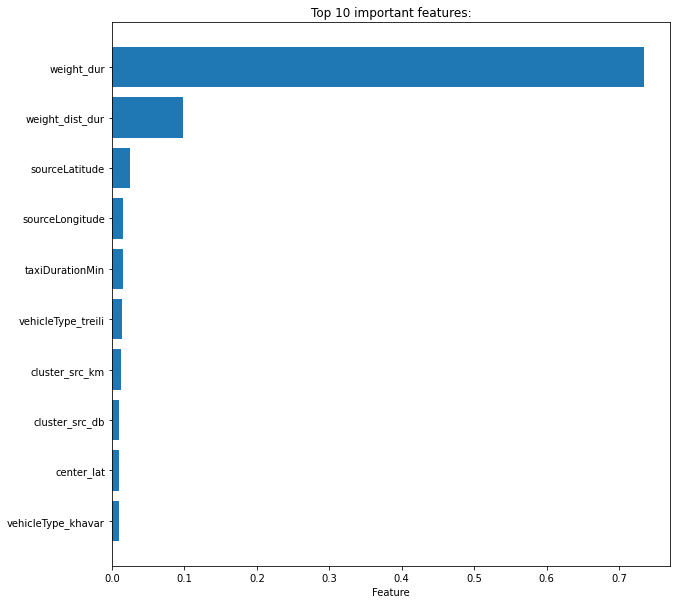

In [12]:
columns_importances, importances = get_sklearn_importances(model, features_columns)

limit = 10
plt.figure(figsize=(10,10))
plt.title(f'Top {limit} important features:')

plt.barh(columns_importances[-limit:], importances[-limit:])
plt.xlabel("Importance")
plt.xlabel("Feature")

1. We clearly overfit to train folds but achive highest score on test folds this way. With more time we could address this issue

2. We also pass clustering information as ordinal variable which may be an issue for many classifiers. In case of decision trees, it requires much more splits 
to imitate categorical variables and may be confusing but on the other hand it allows to use ~50 features instead of 1600+. 

## Training the model for deployment

For sake of simplicity we train a single model without cluster features. We should use the same number iterations as shown in validation - %TODO. 

In [24]:
features_columns = [c for c in features_columns if not c.startswith('cluster_')]

y_full = data['price'].values
x_full = data[features_columns]

preds_train, preds_dev, model_params, model = train_xgb(x_full, y_full, x_full, y_full)

In [25]:
import joblib
joblib.dump(model, os.path.join('..', 'data', 'processed', 'model.bin')) 

['../data/processed/model.bin']